In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [4]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.13.0


In [5]:
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [6]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [7]:
data = raw_dataset.copy()

data = data.dropna() 
#Simple command to drop all rows that contain a Nan value. 
#Note this would mean losing a whole company if they don't report a certain thing. 
#But at the very least its a FAST way to clean the data.

data['Origin'] = data['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
#Map command allows you to map a set of data using a dictionary
#This is useful for transitioning from numerical to categorical data
#It's also a useful tool for transfering from one data type to another...

data =pd.get_dummies(data,columns=['Origin'],prefix_sep='',prefix='')
#This is the second step needed to fully encase the categorical data into categories
#The result of this command shows a dataset that looks like it has been one-hot encoded.

In [8]:
train_data = data.sample(frac=0.8,random_state=0)
test_data = data.drop(train_data.index)
#Apparently PD has built in splitting functions. You can sample a random selection
#If you want to fix that selection to a certain repeatable set, you put in a random state integer
#each integer is like a seed for a random selection. 
#So that being said if you want the same selection months later you can use the same seed.

#We also need to pick what we will predict from the data, lets do MPG
train_labels = train_data.pop('MPG')
test_labels = test_data.pop('MPG')

In [9]:
train_data

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
146,4,90.0,75.0,2125.0,14.5,74,False,False,True
282,4,140.0,88.0,2890.0,17.3,79,False,False,True
69,8,350.0,160.0,4456.0,13.5,72,False,False,True
378,4,105.0,63.0,2125.0,14.7,82,False,False,True
331,4,97.0,67.0,2145.0,18.0,80,False,True,False
...,...,...,...,...,...,...,...,...,...
281,6,200.0,85.0,2990.0,18.2,79,False,False,True
229,8,400.0,180.0,4220.0,11.1,77,False,False,True
150,4,108.0,93.0,2391.0,15.5,74,False,True,False
145,4,83.0,61.0,2003.0,19.0,74,False,True,False


C:\Users\haak\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


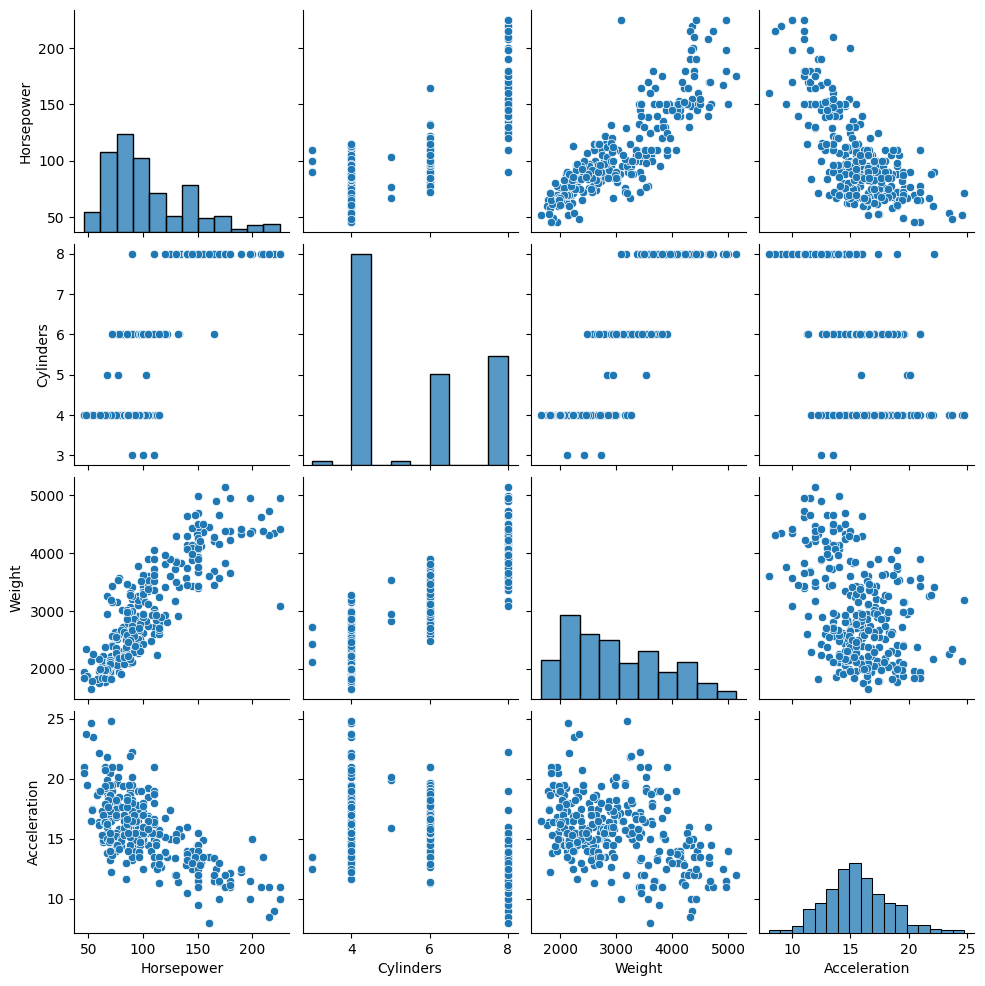

In [10]:
sns.pairplot(train_data[['Horsepower','Cylinders','Weight','Acceleration']])
#Wow this plotting tool is very OP
#It's like a graphical representation of the covariance matrix.
#You can spot relationships between pairs of data right away

In [11]:
train_data.describe()
#This is a more numerical description of the data. But wow!
#Do you see the usefulness of this? No more needing to run a mean function on every column of data or anything like that
#You can just straight up get numerical data distribution statistcs from a single line like this... For the whole set!

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year
count,314.000000,314.000000,314.000000,314.000000,314.000000,314.000000
mean,5.477707,195.318471,104.869427,2990.251592,15.559236,75.898089
std,1.699788,104.331589,38.096214,843.898596,2.789230,3.675642
min,3.000000,68.000000,46.000000,1649.000000,8.000000,70.000000
25%,4.000000,105.500000,76.250000,2256.500000,13.800000,73.000000
50%,4.000000,151.000000,94.500000,2822.500000,15.500000,76.000000
75%,8.000000,265.750000,128.000000,3608.000000,17.200000,79.000000
max,8.000000,455.000000,225.000000,5140.000000,24.800000,82.000000


In [10]:
normalizer = preprocessing.Normalization(axis=-1)
#Axis must be an integer with abs.val. smaller than dim of the data set
#I assume -1 vs +1 is going along rows or columns for a 2D grid. 
#+2 -2 for a 3D data set would be horizontal vs vertical sheets... OTG for three spatial dimensions
#axis=None --> returns a single mean values (mean of all numbers in dataset)
#Normalizing EQ written in One-Note 7-14

In [11]:
normalizer.adapt(np.array(train_data))
#You can choose to feed this layer the statistical parameters manually
#OR just have it calculate on its own with the adapt method, we did this.

#You can check these attributes of the layer to see they were calculated correctly.
normalizer.mean.numpy(),normalizer.variance.numpy()

(array([   5.478,  195.318,  104.869, 2990.252,   15.559,   75.898,
           0.178,    0.197,    0.624], dtype=float32),
 array([     2.88 ,  10850.413,   1446.699, 709896.75 ,      7.755,
            13.467,      0.147,      0.158,      0.235], dtype=float32))

In [12]:
single = np.array(train_data[:1])
normalizer(single)
#Wow ok, and if you feed your layer a single bit of data, like one row of numbers
#You will get a tensor in return apparently. That must be the intermediary data type passed between layers
#Anyway the output is a normalized piece of data, check it out:

<tf.Tensor: shape=(1, 9), dtype=float32, numpy=
array([[-0.871, -1.011, -0.785, -1.027, -0.38 , -0.517, -0.466, -0.496,
         0.776]], dtype=float32)>

In [13]:
###Below is Linear Regression###
#I actually really like doing something simple like this.
#Because it will help me appreciate the differences between basic regression and complex NN regression

bariki = np.array(train_data['Horsepower'])
horse_norm = preprocessing.Normalization(input_shape=[1,],axis=None)
print(f"Shape of 馬力: {bariki.shape}\nTherefore the input shape of [1,] was used")
#Apparently there is some option to define an input shape to the layer. We want it to only take one value at a time
#To that value we are gonna pply simple linear equation y=mx+b, but first normalize...
horse_norm.adapt(bariki)

Shape of 馬力: (314,)
Therefore the input shape of [1,] was used


In [14]:
#build your model, Sequential layers!!!
#Remember you can construct the model two ways
#1) you feed the constructor a vector of layers
#2) you can add them in one by one after.

horsey = tf.keras.Sequential([horse_norm,layers.Dense(units=1)])
#Remember, Dense is a simple layer. You tell it how many nodes you want, and what activation to use
#(I wonder why they needed to specifically define units here, before you just let the first arg be nodes)
#The default activation is linear (therefore its automatically linear regression here)

horsey.summary()
#WOW! A summary method. Very neat.
#You should try this on other models.
#I bet those two trainable params are the m and b in the linear fit! Haha!

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [15]:
#Trial run:
horsey.predict(bariki[:10])
#What does this method even do if we haven't begun to train the thing?
#We haven't told it what we are predicting... We haven't given it labes
#We just said: PREDICT! And it went on its merry way. Is this unsupervised learning?
#No... It's just prediction, its just crunching the linear equation through the data.
#The equation is not yet fit, this is garbage output. I wonder what the default parameter values for m and b are...

array([[ 0.615],
       [ 0.347],
       [-1.135],
       [ 0.862],
       [ 0.78 ],
       [ 0.306],
       [ 0.924],
       [ 0.78 ],
       [ 0.203],
       [ 0.347]], dtype=float32)

In [16]:
#Compiling:
#Ah yes, that's right we haven't even added in the NN components yet. Let's do that
horsey.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')


In [17]:
%%time
#This is interesting, we have a validation option here...
#You can set aside a fraction of the training data to not be trained on actually
#Then the model can iteratively validate on this isolated data set at the end of each run
history = horsey.fit(bariki,train_labels,
           epochs=75,
           verbose=0,
           validation_split=0.2)

Wall time: 1.69 s


(0.0, 10.0)

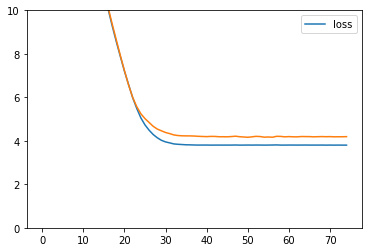

In [18]:
hist = pd.DataFrame(history.history)
plt.plot(hist['loss'],label='loss')
plt.plot(hist['val_loss'])
plt.legend()
plt.ylim(0,10)

In [19]:
#Definine a blank dictionary, lets collect the various test results as we run, with an object like this
test_results = {}
test_results['Bariki Bonanza'] = horsey.evaluate(test_data['Horsepower'],test_labels,verbose=1)

3/3 [==============================] - 0s 2ms/step - loss: 3.6531


In [20]:
#We can check the predict as a function vs the scattered data...
#Basically draw the linear fit over the scatter plot
x = np.linspace(0,250,251)
y = horsey.predict(x)


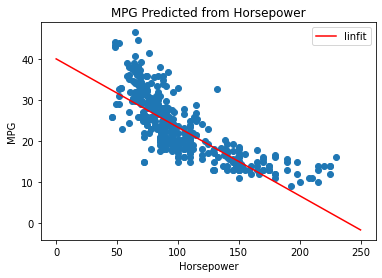

In [21]:
plt.title('MPG Predicted from Horsepower')
plt.xlabel('Horsepower')
plt.ylabel('MPG')
plt.scatter(data['Horsepower'],data['MPG'])
plt.plot(x,y,color='r',label='linfit')
plt.legend()

In [22]:
#Define a model
full_linear = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

#Call the model on some data
full_linear.predict(train_data[:10])

#I made a fuss about the purpose of this earlier but it seems like just calling the model on some data
#it will build the 'weight matrices' and defines the 'kernel' shape.
full_linear.layers[1].kernel

#There is some new vocab here...
#'Weight Matrix' a matrix of weights which will map one layer to the next.
#'Kernel' is also a matrix... But it is variable? It could be the same as the weight matrix in some cases...
#Here the kernel for the final layer is actually just the nine slope values... for each y=mx+b equation

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.226],
       [ 0.671],
       [ 0.545],
       [-0.762],
       [ 0.518],
       [ 0.347],
       [-0.405],
       [-0.537],
       [-0.708]], dtype=float32)>

In [23]:
%%time
#Compile
full_linear.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

#Fit
history = full_linear.fit(
    train_data, train_labels, 
    epochs=100,
    verbose=0,
    validation_split = 0.2)

Wall time: 2.01 s


(0.0, 10.0)

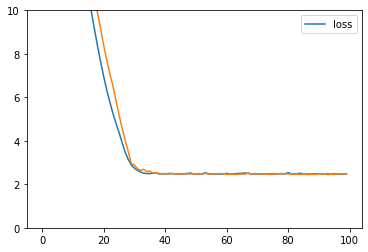

In [24]:
hist = pd.DataFrame(history.history)
plt.plot(hist['loss'],label='loss')
plt.plot(hist['val_loss'])
plt.legend()
plt.ylim(0,10)

In [25]:
#store the results of this multivariable linear model:
test_results['Full Linear'] = full_linear.evaluate(test_data,test_labels,verbose=0)

In [26]:
def double_64(norm):
    """Takes a normalization layer and produces a NN with two hidden layers of 64 nodes each."""
    
    model = keras.Sequential([
        norm,
        layers.Dense(64,activation='relu'),
        layers.Dense(64,activation='relu'),
        layers.Dense(1)
    ])
        
    model.compile(loss='mean_absolute_error',
                 optimizer=keras.optimizers.Adam(0.001))
    return model

deep_horse = double_64(horse_norm)
deep_net = double_64(normalizer)

In [27]:
deep_horse.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [43]:
%%time
hist = deep_horse.fit(train_data['Horsepower'],train_labels,
                      validation_split=0.2,verbose=0,epochs=100)


Wall time: 1.88 s


(0.0, 10.0)

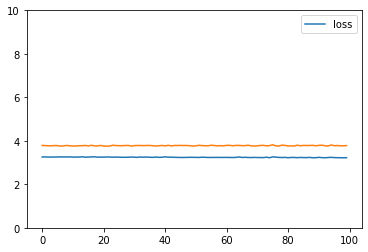

In [44]:
histy = pd.DataFrame(hist.history)
plt.plot(histy['loss'],label='loss')
plt.plot(histy['val_loss'])
plt.legend()
plt.ylim(0,10)

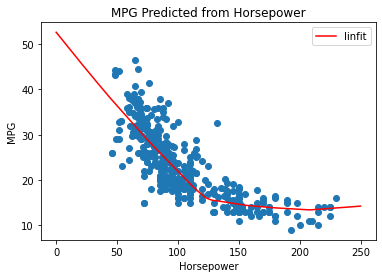

In [32]:
x = np.linspace(0,250,251)
y = deep_horse.predict(x)
plt.title('MPG Predicted from Horsepower')
plt.xlabel('Horsepower')
plt.ylabel('MPG')
plt.scatter(data['Horsepower'],data['MPG'])
plt.plot(x,y,color='r',label='linfit')
plt.legend()

In [33]:
test_results['Deep_Horse'] = deep_horse.evaluate(test_data['Horsepower'],test_labels,verbose=0)

In [28]:
deep_net.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_5 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [34]:
%%time
fit = deep_net.fit(train_data,train_labels,
                  validation_split=0.2,verbose=0,epochs=100)

Wall time: 2.12 s


(0.0, 10.0)

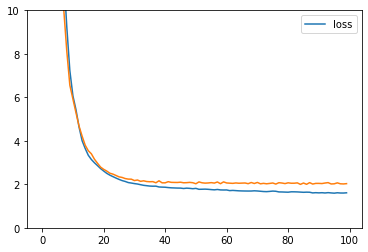

In [39]:
hist = pd.DataFrame(fit.history)
plt.plot(hist['loss'],label='loss')
plt.plot(hist['val_loss'])
plt.legend()
plt.ylim(0,10)

In [37]:
test_results['Deep_Net'] = deep_net.evaluate(test_data,test_labels,verbose=0)

In [38]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
Bariki Bonanza,3.653080
Full Linear,2.428474
Deep_Horse,2.921057
Deep_Net,1.664246


In [60]:
predo = deep_net.predict(test_data).flatten()

Text(0, 0.5, 'Predictions [MPG]')

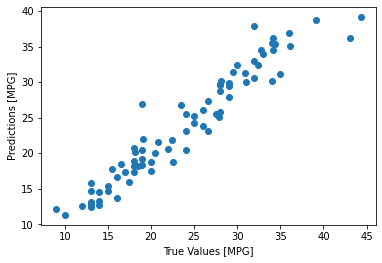

In [66]:
#a = plt.axes(aspect='equal')
plt.scatter(test_labels,predo)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
# lims = [0, 50]
# plt.xlim(lims)
# plt.ylim(lims)
# _ = plt.plot(lims, lims)

Text(0.5, 0, 'Prediction Error [MPG]')

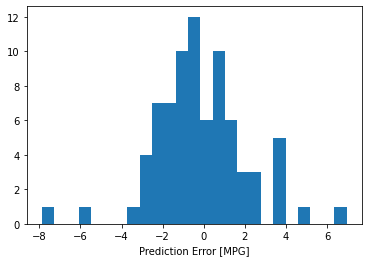

In [67]:
error = test_labels-predo
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')

In [68]:
#A way to save your network for later access even after everything has been shut all down
deep_net.save('reg_tutorial')

INFO:tensorflow:Assets written to: reg_tutorial\assets


In [72]:
#retrieved with the following command
reload = keras.models.load_model('reg_tutorial')
test_results['reloaded'] = reload.evaluate(
    test_data, test_labels, verbose=0)

In [73]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
Bariki Bonanza,3.653080
Full Linear,2.428474
Deep_Horse,2.921057
Deep_Net,1.664246
reloaded,1.664246
